<a href="https://colab.research.google.com/github/wingated/cs474_labs_f2019/blob/master/DL_Lab3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 3: Intro to CNNs and DNNs

## Objectives

* Build and train a deep convolutional net
* Explore and implement various initialization techniques
* Implement a parameterized module in Pytorch
* Use a principled loss function

## Video Tutorial
[https://youtu.be/3TAuTcx-VCc](https://youtu.be/3TAuTcx-VCc)

## Deliverable
For this lab, you will submit an IPython notebook via Learning Suite.
This is where you build your first deep neural network!

For this lab, we'll be combining several different concepts that we've covered during class,
including new layer types, initialization strategies, and an understanding of convolutions.

## Grading Standards:
* 20% Part 0: Successfully followed lab video and typed in code
* 20% Part 1: Re-implement Conv2D and CrossEntropy loss function
* 20% Part 2: Implement different initialization strategies
* 10% Part 3: Print parameters, plot train/test accuracies
* 10% Reach 85% validation accuracy from parts 1-3
* 10% Part 4: Convolution parameters quiz
* 10% Tidy and legible figures, including labeled axes where appropriate
___

### Part 0
Watch and follow video tutorial:

[https://youtu.be/3TAuTcx-VCc](https://youtu.be/3TAuTcx-VCc)

**TODO:**

**DONE:**

* Watch tutorial


In [ ]:
!pip3 install torch
!pip3 install torchvision
!pip3 install tqdm

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, utils, datasets
from tqdm import tqdm
from torch.nn.parameter import Parameter
import pdb

assert torch.cuda.is_available(), "You need to request a GPU from Runtime > Change Runtime"

In [2]:
# code up our own convolution operator
class Conv2d(nn.Module):
  def __init__(self, n_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, init='xavier'):
    self.__dict__.update(locals())
    super(Conv2d, self).__init__()

    shape = (out_channels, n_channels, kernel_size, stride) # (out, in, k, k) needs this shape
    self.weight = Parameter(torch.Tensor(self.out_channels,
                                         self.n_channels,
                                         kernel_size[0],
                                         kernel_size[1]))
    self.bias = Parameter(torch.Tensor(self.out_channels))
    #pdb.set_trace()
    # Initialize our tensors manualy - part of the lab####################
    if init == 'xavier':
      var = 2 / (n_channels + out_channels)
      #torch.nn.init.uniform_(self.weight, -var, var)
      nn.init.xavier_uniform_(self.weight)

    elif init == 'orthogonal':
      #pdb.set_trace()
      temp = np.random.random((out_channels, n_channels * kernel_size[0] * kernel_size[0])).astype(np.float32)
      U,_,Vt = np.linalg.svd(temp, full_matrices=False)
      if len(temp) > len(temp[0]):
        W = U.reshape(out_channels, n_channels, kernel_size[0], kernel_size[0])
      else:
        W = Vt.reshape(out_channels, n_channels, kernel_size[0], kernel_size[0])
      self.weight.data = torch.from_numpy(W)
      
    elif init == 'uniform':
      torch.nn.init.uniform_(self.weight,-1,1)
    
    self.bias.data.uniform_(0,0)

  def forward(self, x):
    # input, weight, bias, stride, padding -> args
    return F.conv2d(x, self.weight, self.bias, self.stride, self.padding, self.dilation, self.groups)

  def extra_repr(self):
    return "Tesla is so cool"

class CrossEntropyLoss(nn.Module):
  def __init__(self, weight=None, size_average=None, ignore_index=-100, reduce=None, reduction='mean'):
    # Use the default CrossEntropyLoss's init function
    super(CrossEntropyLoss, self).__init__()

  def forward(self, y_hat, y_truth):
    # a =  torch.max(y_hat, 1).values
    # Compute the penalty using the probabilities for the wrong classes
    penalty = torch.log(torch.sum(torch.exp(y_hat), dim=1))
    # Create a one-hot encoding matrix of th e y_truth
    #pdb.set_trace()
    batch_size, num_classes = y_hat.size()
    truth_matrix = torch.zeros(y_hat.size()) #Size = (batch_size, num_classes)
    truth_matrix[np.arange(batch_size), y_truth] = 1 #Make the truth 1 , while everything else is 0s
    # Compute x[class] for each batch example 
    true_class_scores = torch.sum(y_hat * truth_matrix.cuda(), dim=1)
    # Return the mean prediction loss over the whole batch
    return torch.mean(-true_class_scores + penalty)

# class CrossEntropyLoss2(nn.Module):
#   def __init__(self, weight=None, size_average=None, ignore_index=-100, reduce=None, reduction='mean'):
#     self.__dict__.update(locals())
#     super(CrossEntropyLoss, self).__init__()

#   # y_truth is one hot encoded with torch.one_hot()
#   def forward(self, y_hat, y_truth):
#     #pdb.set_trace()
#     penalty = torch.log(torch.sum(torch.exp(y_hat), dim=1))
#     r = len(y_truth) # batch size
#     c = y_truth
#     row = torch.arange(y_hat.size(0))
#     exp_yhat = torch.exp(y_hat)
#     log_exp = torch.log(exp_yhat.sum(1, keepdim=True))
#     loss = -y_hat[row,c] + log_exp
#     # current_probabilities = y_hat[np.arange(r), c] # slices all of the rows at y_truth
#     #current_probabilities = torch.sum(y_truth * y_hat, dim=1) # probs I'm interested in /  sum along the rows

#     #compare to the penalty of the all of the other logits we don't want
#     #loss = torch.mean(-1 * (current_probabilities - penalty)) # To maxmize the whole statement (minimizing the negative)
#     return loss.mean()

    # y_hat_softmax = torch.softmax(y_hat, dim=1).float()
    # loss = -1 * torch.sum(y_truth * torch.log(y_hat_softmax))

class ConvNetwork(nn.Module):
  def __init__(self, dataset, init='uniform'):
    super(ConvNetwork, self).__init__() # Call it's init fn() - basically just lets super class know that it exists and get all the parameters attached to this class to the super class. Very important
    x, y = dataset[0]
    c, h, w = x.size() # channel, height, width, 
    # pdb.set_trace()

    out_dim = 10 # Hard coded answer
    # ADD RELU AND MORE CONVOLUTIONS TO BE ABOUT 1M PARAMETERS
    # pdb.set_trace()
  
    self.net = nn.Sequential(Conv2d(c, 32, (3,3), padding=(1,1), init=init),
                             nn.ReLU(),
                             Conv2d(32, 64, (3,3), padding=(0,0), init=init),
                             nn.ReLU(),
                             Conv2d(64, 64, (3,3), padding=(0,0), init=init),
                             nn.ReLU(),
                             Conv2d(64, 64, (3,3), padding=(0,0), init=init),
                             nn.ReLU(),
                             Conv2d(64, 64, (22,22), padding=(0,0), init=init),
                             nn.ReLU(),
                             Conv2d(64, out_dim, (1,1), padding=(0,0), init=init),
                             nn.ReLU(),
                             )
                             

                            #  Conv2d(96, 64, (3,3), padding=(0,0), init=init),
                            #  nn.ReLU(),
                            #  Conv2d(64, 32, (3, 3), padding=(0,0), init=init),
                            #  nn.ReLU(),
                            #  Conv2d(32, out_dim, (28, 28), init=init),
                            #  nn.ReLU())
                             #Conv2d(output, output, (1,1), init=init)) # final size needs to be batch_size x 10 x 1 x 1

    #pdb.set_trace()
  
    
    # self.net = nn.Sequential(Conv2d(c, 32, (3,3), padding=(1,1), init=init),
    #                          nn.ReLU(),
    #                          Conv2d(32, 64, (3,3), padding=(0,0), init=init),
    #                          nn.ReLU(),
    #                          Conv2d(64, 96, (3,3), padding=(0,0), init=init),
    #                          nn.ReLU(),
    #                          Conv2d(96, 64, (3,3), padding=(0,0), init=init),
    #                          nn.ReLU(),
    #                          Conv2d(64, 32, (3, 3), padding=(0,0), init=init),
    #                          nn.ReLU(),
    #                          Conv2d(32, out_dim, (28, 28), init=init),
    #                          nn.ReLU())
    #                          #Conv2d(output, output, (1,1), init=init)) # fin
                             
                            
    
  def forward(self, x):
    # batch size, 10, 1 X 1
    # x is (n, 10, 1, 1)
    # We want a batch size x 10 so we squeeze out this dimention -> (n, 10, 1)
    # Squeeze image again to get rid of the last one -> (n, 10)

    return self.net(x).squeeze(2).squeeze(2)
    # Use the dataset class you created in lab2

class FashionMNISTProcessedDataset(Dataset):
  def __init__(self, root, train=True):
    self.data = datasets.FashionMNIST(root, train=train,
                                      transform=transforms.ToTensor(),# Augment data, in this case just transform into tensors
                                      download=True)
  def __getitem__(self, i):
    x, y = self.data[i]
    return x, y
  
  def __len__(self):
    return len(self.data) # If you put 100 it would cut off the training after 100 elements

In [3]:
validations = []
losses = []
accuracy_val = []
accuracy_train = []

def run_cnn(init='uniform', epochs=15):
  train_dataset = FashionMNISTProcessedDataset('/tmp/fashionmnist', train=True)
  val_dataset = FashionMNISTProcessedDataset('/tmp/fashionmnist', train=False)

  # Initialize DataLoaders
  train_loader = DataLoader(train_dataset, batch_size=100, pin_memory=True)
  val_loader = DataLoader(val_dataset, batch_size=100, pin_memory=True)

  # Instantiate your model and loss and optimizer functions
  model = ConvNetwork(train_dataset, init)
  model = model.cuda() # can't multiply two things one on gpu and one on cpu

  #Optimizer is the thing that takes the step to make the model better
  objective = CrossEntropyLoss() #MSE->classification prob...etc
  optimizer = optim.SGD(model.parameters(), lr=1e-4) # What actually updates the model parameters

  # Instantiate your data loaders
  train_loader = DataLoader(train_dataset, batch_size=42, pin_memory=True) # Pin memory makes it faster with memory somehow
  val_loader = DataLoader(val_dataset, batch_size=42) # n batches x c channels x h height x w width

  # losses = []
  # accuracy_list = []
  # validations = []
  num_epochs = 100
  batch = 0
  # Run your training / validation loops
  for epoch in range (num_epochs):
    if epoch == epochs:
        return 
    #loop = tqdm(total=len(train_loader) * num_epochs, position=0)

    for batch, (x, y_truth) in enumerate(train_loader):
      #y_truth = F.one_hot(y_truth)
      x, y_truth = x.cuda(), y_truth.cuda() 

      optimizer.zero_grad()
      y_hat = model(x) 

      #pdb.set_trace()
      loss = objective(y_hat, y_truth) 
      loss.backward() # Computing the gradient
      losses.append(loss.item()) # store loss

      # Training set accuracy after each batch
      # pdb.set_trace()
      preds = torch.max(y_hat, 1) # Returns tuple of max's and indexes
      preds = preds.indices.reshape((y_truth.shape)) # y_truth.shape = (42) not always though because batch size can differ
      correct = preds == y_truth
      accuracy = torch.sum(correct).item() / len(correct)
      accuracy_train.append((len(accuracy_train), accuracy))

      #loop.set_description('epoch:{}, batch:{}, loss:{:.4f}, accuracy:{:.3f}'.format(epoch, batch, loss.item(), accuracy))
      #loop.update(1)
      optimizer.step() # Taking that step based on the gradient we computed

      if batch % 500 == 0:
        # this gives me all of the losses by passing in my x's and comparing them to my y's
        # returns tensors so to get the first element in the tensor call item()
        # then compute the mean of the losses
        val = np.mean([objective(model(x.cuda()), y.cuda()).item()
                      for x, y in val_loader])
        validations.append((len(losses), val)) 

        # Calc Accuracy after each batch
        with torch.no_grad():
          model.eval()
          with torch.no_grad():
            correct = 0
            total = 0

            for images, labels in val_loader:
              images = images.cuda()
              labels = labels.cuda()

              outputs = model(images)
              _, predicted = torch.max(outputs.data, 1)
              # pdb.set_trace()
              total += labels.size(0)
              correct += (predicted == labels).sum().item()
            
            accuracy_val.append((len(accuracy_train), correct / total)) # Make first term be length of batches so it graphs good with the training accuracies
        print('epoch:{}, batch:{}, loss:{:.4f}, accuracy:{:.3f}'.format(epoch, batch, loss.item(),100 * accuracy))
      

    #loop.close()


In [ ]:
# Initializing random numbers
w_test = np.random.random([10,10]) # Continuous uniform distribution
w = np.random.randn(10,10) # Gaussian distribution of random numbers
print(test)
print(w)

In [ ]:
# Numpy by itslf produces float64
np.random.randn(10,10).dtype
# Normally use float32 in tensorflow
np.random.randn(10,10).astype(np.float32).dtype
# or
torch.from_numpy(np.random.randn(10,10)).float().dtype

In [ ]:
def robertsfunction(*args, **kwargs):
  print(args)
  print(kwargs)
robertsfunction(1,2,3, robert='cool')

___

### Part 1
Re-implement a Conv2D module with parameters and a CrossEntropyLoss function. Do not use PyTorch's implementation of cross entropy loss (F.cross_entropy or nn.CrossEntropyLoss) for your re-implementation of cross entropy loss. You may use PyTorch's functional implemenation of 2D convolution in your Conv2D module.

**TODO:**

**DONE:**
* CrossEntropyLoss 
* Conv2D
___

### Part 2
Implement three initialization strategies: Xe initialization
(sometimes called Xavier), orthogonal initialization, and uniform random initialization.
You can specify which strategy you want to use with a parameter.



Helpful links include:
*  [Orthogonal Initialization](https://hjweide.github.io/orthogonal-initialization-in-convolutional-layers) (or the original paper: http://arxiv.org/abs/1312.6120)
*  http://andyljones.tumblr.com/post/110998971763/an-explanation-of-xavier-initialization

**TODO:**

**DONE:**
* Parameterize custom Conv2D for different initilization strategies
* Xe
* Orthogonal
* Uniform



In [ ]:
class CrossEntropyLoss(nn.Module):
  pass

class Conv2d(nn.Module):
  pass


In [ ]:
class ConvNetwork(nn.Module):
  pass


In [ ]:
# Initialize Datasets

# Initialize DataLoaders

# Initialize Model

# Initialize Objective and Optimizer and other parameters


In [ ]:

# Run your training and validation loop and collect stats



___

### Part 3
Print the number of parameters in your network and plot accuracy of your training and validation 
set over time. You should experiment with some deep networks and see if you can get a network 
with close to 1,000,000 parameters.

Once you've experimented with multiple network setups and the different initialization strategies, plot the best-performing experiments with each initialization strategy. You should be able to exceed 85% accuracy on the validation set in at least one of the plotted experiments.

**TODO:**
* Experiment with Deep Networks
* Plot accuracy of training and validation set over time for each initialization strategy (w/ accurate graph title and axes lables)
* Plot experiment results with 85% or better validation accuracy
* Print out number of parameters in the model 

**DONE:**


In [ ]:
# Go back up and try a few different networks and initialization strategies
validations = []
losses = []
accuracy_val = []
accuracy_train = []

run_cnn('uniform')


# Plot training and validation loss for uniform initialization
batch, values = zip(*validations)

plt.figure(1)
plt.plot(losses, label='train')
plt.plot(batch, values, label='val')
plt.ylabel('Loss')
plt.xlabel('Batch')
plt.title('Uniform Initialization')
plt.legend()
# Plot training and validation accuracy for uniform initialization

plt.figure(2)
batch, values = zip(*accuracy_val)
batch_train, batch_val = zip(*accuracy_train)
plt.plot(batch_train, batch_val, label='train')
plt.plot(batch, values, label='val')
plt.ylabel('Accuracy')
plt.xlabel('Batch')
plt.title('Uniform Initialization')
plt.legend()
plt.show()


epoch:0, batch:0, loss:147992.0469, accuracy:14.286
epoch:0, batch:500, loss:nan, accuracy:4.762


KeyboardInterrupt: ignored

epoch:0, batch:0, loss:2.3027, accuracy:9.524
epoch:0, batch:500, loss:2.2993, accuracy:14.286
epoch:0, batch:1000, loss:2.2955, accuracy:16.667
epoch:1, batch:0, loss:2.2890, accuracy:14.286
epoch:1, batch:500, loss:2.2892, accuracy:21.429
epoch:1, batch:1000, loss:2.2842, accuracy:19.048
epoch:2, batch:0, loss:2.2705, accuracy:33.333
epoch:2, batch:500, loss:2.2740, accuracy:30.952
epoch:2, batch:1000, loss:2.2570, accuracy:23.810
epoch:3, batch:0, loss:2.2319, accuracy:35.714
epoch:3, batch:500, loss:2.2405, accuracy:30.952
epoch:3, batch:1000, loss:2.1998, accuracy:26.190
epoch:4, batch:0, loss:2.1448, accuracy:38.095
epoch:4, batch:500, loss:2.1722, accuracy:28.571
epoch:4, batch:1000, loss:2.0906, accuracy:28.571
epoch:5, batch:0, loss:1.9808, accuracy:50.000
epoch:5, batch:500, loss:2.0739, accuracy:35.714
epoch:5, batch:1000, loss:1.9327, accuracy:40.476
epoch:6, batch:0, loss:1.7937, accuracy:54.762
epoch:6, batch:500, loss:1.7925, accuracy:47.619
epoch:6, batch:1000, loss:1.5

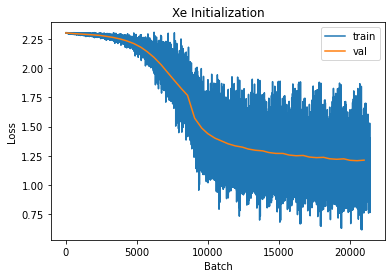

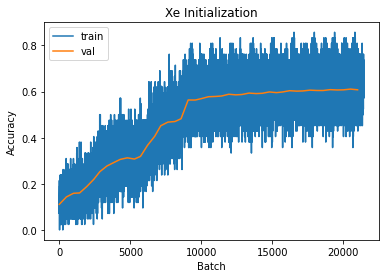

In [ ]:
validations = []
losses = []
accuracy_val = []
accuracy_train = []

run_cnn('xavier')

# Plot training and validation loss for Xe initialization
batch, values = zip(*validations)

plt.figure(1)
plt.plot(losses, label='train')
plt.plot(batch, values, label='val')
plt.ylabel('Loss')
plt.xlabel('Batch')
plt.title('Xe Initialization')
plt.legend()

# Plot training and validation accuracy for Xe initialization

plt.figure(2)
batch, values = zip(*accuracy_val)
batch_train, batch_val = zip(*accuracy_train)
plt.plot(batch_train, batch_val, label='train')
plt.plot(batch, values, label='val')
plt.ylabel('Accuracy')
plt.xlabel('Batch')
plt.title('Xe Initialization')
plt.legend()
plt.show()


epoch:0, batch:0, loss:2.3020, accuracy:7.143
epoch:0, batch:500, loss:2.2946, accuracy:21.429
epoch:0, batch:1000, loss:2.2868, accuracy:38.095
epoch:1, batch:0, loss:2.2811, accuracy:30.952
epoch:1, batch:500, loss:2.2620, accuracy:38.095
epoch:1, batch:1000, loss:2.2536, accuracy:45.238
epoch:2, batch:0, loss:2.2460, accuracy:33.333
epoch:2, batch:500, loss:2.1888, accuracy:47.619
epoch:2, batch:1000, loss:2.1708, accuracy:40.476
epoch:3, batch:0, loss:2.1528, accuracy:30.952
epoch:3, batch:500, loss:1.9772, accuracy:52.381
epoch:3, batch:1000, loss:1.9646, accuracy:40.476
epoch:4, batch:0, loss:1.9428, accuracy:42.857
epoch:4, batch:500, loss:1.6452, accuracy:54.762
epoch:4, batch:1000, loss:1.8056, accuracy:42.857
epoch:5, batch:0, loss:1.7804, accuracy:42.857
epoch:5, batch:500, loss:1.5293, accuracy:57.143
epoch:5, batch:1000, loss:1.7563, accuracy:42.857
epoch:6, batch:0, loss:1.6899, accuracy:40.476
epoch:6, batch:500, loss:1.4940, accuracy:54.762
epoch:6, batch:1000, loss:1.7

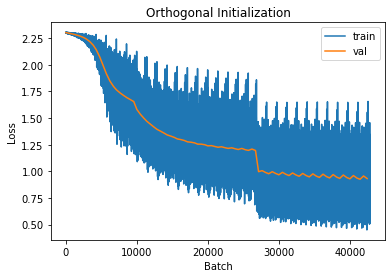

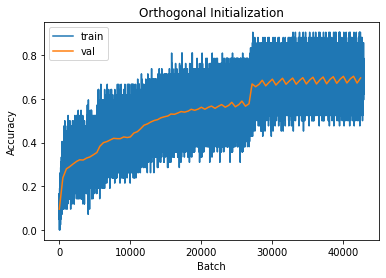

In [5]:
validations = []
losses = []
accuracy_val = []
accuracy_train = []

run_cnn('orthogonal', 30)

# Plot training and validation loss for orthogonal initialization
batch, values = zip(*validations)

plt.figure(1)
plt.plot(losses, label='train')
plt.plot(batch, values, label='val')
plt.ylabel('Loss')
plt.xlabel('Batch')
plt.title('Orthogonal Initialization')
plt.legend()

# Plot training and validation accuracy for orthogonal initialization

plt.figure(2)
batch, values = zip(*accuracy_val)
batch_train, batch_val = zip(*accuracy_train)
plt.plot(batch_train, batch_val, label='train')
plt.plot(batch, values, label='val')
plt.ylabel('Accuracy')
plt.xlabel('Batch')
plt.title('Orthogonal Initialization')
plt.legend()
plt.show()



In [ ]:
# Compute and print the number of parameters in the model
# !pip -vvv install prettyTable
# from prettytable import PrettyTable
train_dataset = FashionMNISTProcessedDataset('/tmp/fashionmnist', train=True)


def count_parameters(model):
  table = PrettyTable(["Modules", "Parameters"])
  total_params = 0
  for name, parameter in model.named_parameters():
    if not parameter.requires_grad: continue
    param = parameter.numel() # returns the total number of elements in the input tensor
    table.add_row([name, param])
    total_params+=param
  print(table)
  print(f"Total trainable params: {total_params}")
  return total_params

test_model = ConvNetwork(train_dataset, 'orthogonal')

count_parameters(test_model)


+---------------+------------+
|    Modules    | Parameters |
+---------------+------------+
|  net.0.weight |    288     |
|   net.0.bias  |     32     |
|  net.2.weight |   18432    |
|   net.2.bias  |     64     |
|  net.4.weight |   36864    |
|   net.4.bias  |     64     |
|  net.6.weight |   36864    |
|   net.6.bias  |     64     |
|  net.8.weight |  1982464   |
|   net.8.bias  |     64     |
| net.10.weight |    640     |
|  net.10.bias  |     10     |
+---------------+------------+
Total trainable params: 2075850


2075850

___

### Part 4
Learn about how convolution layers affect the shape of outputs, and answer the following quiz questions. Include these in a new markdown cell in your jupyter notebook.


*Using a Kernel size of 3×3 what should the settings of your 2d convolution be that results in the following mappings (first answer given to you)*

* (c=3, h=10, w=10) ⇒ (c=10, h=8, w=8) : (out_channels=10, kernel_size=(3, 3), padding=(0, 0))
* (c=3, h=10, w=10) ⇒ (c=22, h=10, w=10) : (out_channels=22, kernel_size(3,3), padding=(1,1))
* (c=3, h=10, w=10) ⇒ (c=65, h=12, w=12) : (out_channels=65, kernel_size(3,3), padding=(2,2))
* (c=3, h=10, w=10) ⇒ (c=7, h=20, w=20) : (out_channels=7, kernel_size(3,3), padding=(6,6))

*Using a Kernel size of 5×5:*)

* (c=3, h=10, w=10) ⇒ (c=10, h=8, w=8) : (out_channels=10, kernel_size=(5, 5), padding=(1, 1))
* (c=3, h=10, w=10) ⇒ (c=100, h=10, w=10) : (out_channels=100, kernel_size(5,5, padding=(2,2))
* (c=3, h=10, w=10) ⇒ (c=23, h=12, w=12) : (out_channels=23, kernel_size(5,5), padding=(3,3))
* (c=3, h=10, w=10) ⇒ (c=5, h=24, w=24) : (out_channels=5, kernel_size(5,5), padding=(9,9))

*Using Kernel size of 5×3:*

* (c=3, h=10, w=10) ⇒ (c=10, h=8, w=8) : (out_channel=10, kernel_size=(5,3), padding=(1,0))
* (c=3, h=10, w=10) ⇒ (c=100, h=10, w=10) : (out_channels=100, kernel_size=(5,3), padding=(2,1))
* (c=3, h=10, w=10) ⇒ (c=23, h=12, w=12) : (out_channels=23, kernel_size=(5,3), padding=(3,2))
* (c=3, h=10, w=10) ⇒ (c=5, h=24, w=24) : (out_cahnnels=5, kernel_size=(5,3), padding=(9,8))

*Determine the kernel that requires the smallest padding size to make the following mappings possible:*

* (c=3, h=10, w=10) ⇒ (c=10, h=9, w=7) : (out_channels=10, kernel_size(2,4), padding=(0,0))
* (c=3, h=10, w=10) ⇒ (c=22, h=10, w=10) : (out_channels=22, kernel_size(1,1), padding=(0,0))

**TODO:**

**DONE:**
* Answer all the questions above 


######################################################NOTES####################


In [ ]:
# Write some test code for checking the answers for these problems (example shown in the video)


In [ ]:
## tips ##
# Create cross entropy loss the same way we created the other modules (init fn and forward fn)
# forward() takes in 2 items -> same api as the cross entropy loss fn in pytorch

# More tips
a = torch.from_numpy(np.random.randn(42,10,1).astype(np.float32))
# run this through torch.exp(a)

In [ ]:
b = torch.exp(a)
b.sum()# don't do this because you don't want the sum over the entire batch
c = b.sum(dim=1) # Sum over the rows(1 for each row of the batch)
#print(c.size())
a.size(), b.sum(1, keepdim=True).size()
# vs
print(a.size())
print(b.size())
# a.size(), b.sum(1).size()
# Now we can do
print(b.sum(1).size())
z = a / b.sum(1, keepdim=True) # Called broadcasting
print(z.size())

In [ ]:
i.dtype

In [ ]:
# EX
a = torch.from_numpy(np.random.randn(3,10,1).astype(np.float32))
b = torch.exp(a)
i = torch.tensor([1,7,2], dtype=torch.int64) # Grab the first 3 indexes of truths 
row = torch.arange(b.size(0))
col = i
b[row, col]


In [ ]:
print(b.shape) # This is a batch with 3 instances with 4 classes in each
print("All of the batches but only the first index", b[:,0].size())
print(b)

In [ ]:
# Accuracy - Output from your model is an enormous tensor with numbers for each class that you're predicting. You might want to know what the argmax is (convert to probabilities)
torch.softmax(y_hat, dim=1) # Converted to probabilities between 0 and 1 -  Can't use on cross entropy fn
torch.softmax(y_hat,dim=1).argmax(1) == y_truth
(torch.softmax(y_hat,dim=1).argmax(1) == y_truth).float().mean() # Avg accuracy is 23%
# Compute for each batch and average it out


In [ ]:
# Compute the total number of paramenters in the model
for p in model.parameters():
  print(p.size())
  for s in p.size():
    print(s)

# Do a list comprehension
# np.prod() - multiplies a list of numbers together
np.prod(range(1,10))

In [ ]:
# Chaning kernel size
# What do i need to do this? The output chaneel is decided for you just specify out_channels
# Kernel size is given to you and you have you figure out the padding
#(c=3, h=10, w=10) => (c=10, h=u, w=8) : out = 10, kernel_size(3,3), padding=(0,0)

c = nn.Conv2d(3, 10, kernel_size=(3,3), padding=(0,0))
# run convolution on tensor of zero size 1 by batch
c(torch.zeros(1,3,10,10)).size()